# EfficientNetV2L

## Description

**Codabench accuracy** : 0.86

**Local test accuracy**: 0.98 (0.99 using TTA, tested on `Submission_with_TTA.ipynb`)

**Description**: Using an even bigger network combined with a properly build augmentation pipeline using a random mix of RandAugment, CutMix, Mixup and Gridmask. This has also been trained way deeper (110M o parameters retrained) to better fit the problem.

**Motivation**: Trying to exploit a bigger generalization capability and the huge number of parameters to build the most powerful network we have ever built.

## Google Drive - Connecting to the project

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1"
%cd {project_path}
sys.path.append(project_path)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1


In [ ]:
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 57.9 MB/s eta 0:00:00


## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import utils

import numpy as np
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
import keras_cv
import matplotlib.pyplot as plt

from tensorflow.keras.applications import EfficientNetV2L
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Parameters

In [ ]:
# We are dealing with an 8-class problem with 96x96 RGB images as input
OUTPUT_SIZE = 8
INPUT_SHAPE = (96,96,3)
BATCH_SIZE = 64

## Load Data

In [ ]:
# Parameters used for loading the data with augmentation
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 8
RATE = 0.3
AUG_PER_IMAGE = 3
MULT = 3

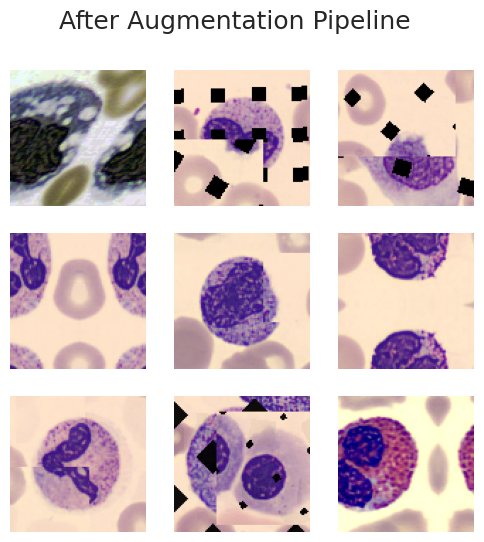

In [ ]:
# Get a standard set of image augmentation policies
rand_aug = keras_cv.layers.RandAugment.get_standard_policy(
        value_range=(0,255),
        magnitude=0.75,
        magnitude_stddev=0.3,
    )

# Remove specific types of augmentation layers from this list (Solarization and RandomColorDegeneration)
rand_aug = [layer for layer in rand_aug if
            not isinstance(layer, keras_cv.layers.Solarization)
            and not isinstance(layer,keras_cv.layers.RandomColorDegeneration)]

# Creation of a random image augmentation pipeline
rand_aug = keras_cv.layers.RandomAugmentationPipeline(
    layers = rand_aug, augmentations_per_image=AUG_PER_IMAGE, rate=RATE
)

# Creation of three  instances of three different data augmentation techniques
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()
grid_mask = keras_cv.layers.GridMask()

# Function used to apply the augmentation to the images
def preprocess(images, labels):
    samples = {"images": images, "labels": labels}

    if tf.random.uniform(()) > 0.5:
        samples = rand_aug(samples)
    else:
        if tf.random.uniform(()) > RATE:
            samples = grid_mask(samples)

        if tf.random.uniform(()) > RATE:
            samples = cut_mix(samples)

        if tf.random.uniform(()) > RATE:
            samples = mix_up(samples)

    return samples["images"], samples["labels"]

# Cleaned dataset loading with a split in three datasets: training, validation, and test
X, y = utils.load_cleaned_dataset()
X_train, X_val, X_test, y_train, y_val, y_test = utils.split_dataset(X, y, test_size=0.2, val_size=0.2)

# Converts numpy arrays into tensorflow dataset applying automatic prefetching and setting batch size
def convert_into_dataset(X, y, split=""):
    X = tf.cast(X, tf.float32)
    y = tf.one_hot(y, NUM_CLASSES)
    y = tf.cast(y, tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if split == "train":
        dataset = dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    else:
        dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

# Actual conversion of the numpy datasets into tensorflow datasets
train_data = convert_into_dataset(X_train, y_train, split="train")
val_data = convert_into_dataset(X_val, y_val)

# Augmentation and expansion the training, validation, and test datasets
for _ in range(MULT):
    new_train_data = train_data.map(preprocess, num_parallel_calls=AUTOTUNE)
    new_train_data = new_train_data.concatenate(new_train_data)
    new_val_data = val_data.map(preprocess, num_parallel_calls=AUTOTUNE)
    new_val_data = new_val_data.concatenate(new_val_data)

# Duplication of the datasets
train_data = new_train_data
val_data = new_val_data

# Function for the dataset visualization
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6))
    plt.suptitle(title, fontsize=18)
    for i, (images, labels) in enumerate(dataset.take(9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

# Visualize the dataset
visualize_dataset(train_data, title="After augmentation pipeline")

## Model Implementation

In [ ]:
# Importing of the model EfficientNetV2L without dense layers
efficientNet = EfficientNetV2L(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
efficientNet.trainable = False

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


In [ ]:
# Definition of the model
def build_model():
    # The input layer takes 96x96 RGB images
    input_layer = tfkl.Input(shape=INPUT_SHAPE, name='Input')

    # Addition of EfficientNetV2B3 to the model
    x = efficientNet(input_layer)

    # GAP, dropout, dense, and ReLU layers for the top of the network
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dense(2048)(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Dense(1024)(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Dense(512)(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Dense(256)(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Dense(128)(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Dense(64)(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Dense(32)(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Dense(16)(x)
    x = tfkl.ReLU()(x)

    # Dense layer as output
    output_layer = tfkl.Dense(OUTPUT_SIZE, activation='softmax', dtype='float32', name='Output')(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
# Definition of the leraning rate for Adam optimizer
LR = 1e-3

In [ ]:
# Model contruction
model = build_model()

# Model compilation with Adam as optimizer and sparse categorical crossentropy as loss function
model.compile(optimizer=tfk.optimizers.Adam(LR),
              loss=tfk.losses.CategoricalCrossentropy(), #Sparse since we are not one-hot-encoding (no difference)
              metrics=['accuracy'])

# Print model details
model.summary()

output dtype :  float32


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-l (Functional)        │ (None, 3, 3, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,168,536 (469.85 MB)

 Trainable params: 5,421,688 (20.68 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

## Training

In [ ]:
# Parameters used for training
EPOCHS = 100
PATIENCE = 5

In [ ]:
# Implementation of early stopping as a technique to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
callbacks = [early_stopping]

In [ ]:
# Actual training of the model with the given parameters
history = model.fit(train_data,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    validation_data=val_data).history

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 245s 492ms/step - accuracy: 0.2849 - loss: 1.8071 - val_accuracy: 0.5821 - val_loss: 1.2366
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.5910 - loss: 1.2069 - val_accuracy: 0.6528 - val_loss: 1.1263
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.6244 - loss: 1.1598 - val_accuracy: 0.6898 - val_loss: 0.9757
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.6597 - loss: 1.0814 - val_accuracy: 0.7506 - val_loss: 0.8018
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.6636 - loss: 1.0749 - val_accuracy: 0.7120 - val_loss: 0.9501
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.7076 - loss: 0.9585 - val_accuracy: 0.7061 - val_loss: 0.9421
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.6741 - loss: 1.0531 - val_accuracy: 0.6969 - val_loss: 1.0010
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.6900 - loss: 0.9695 

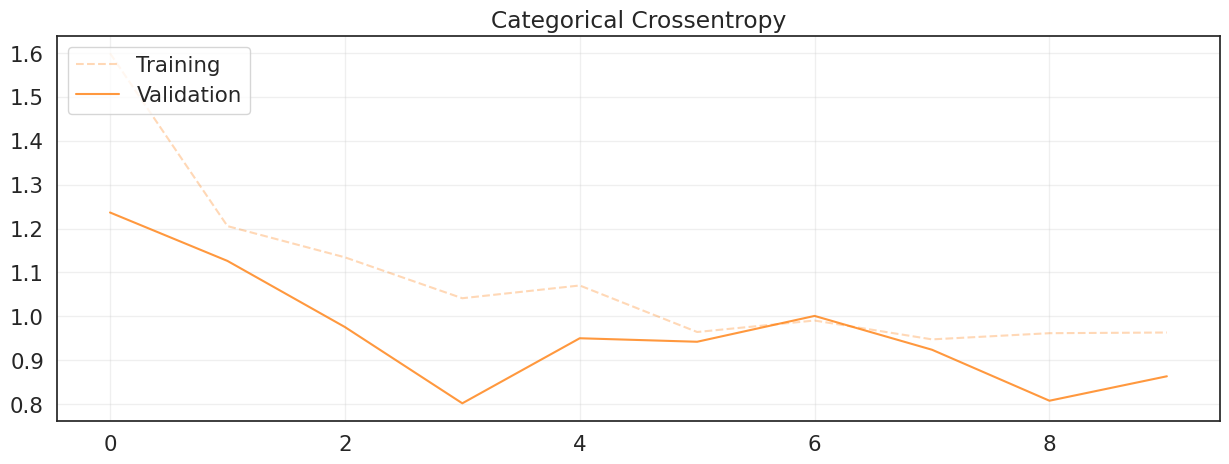

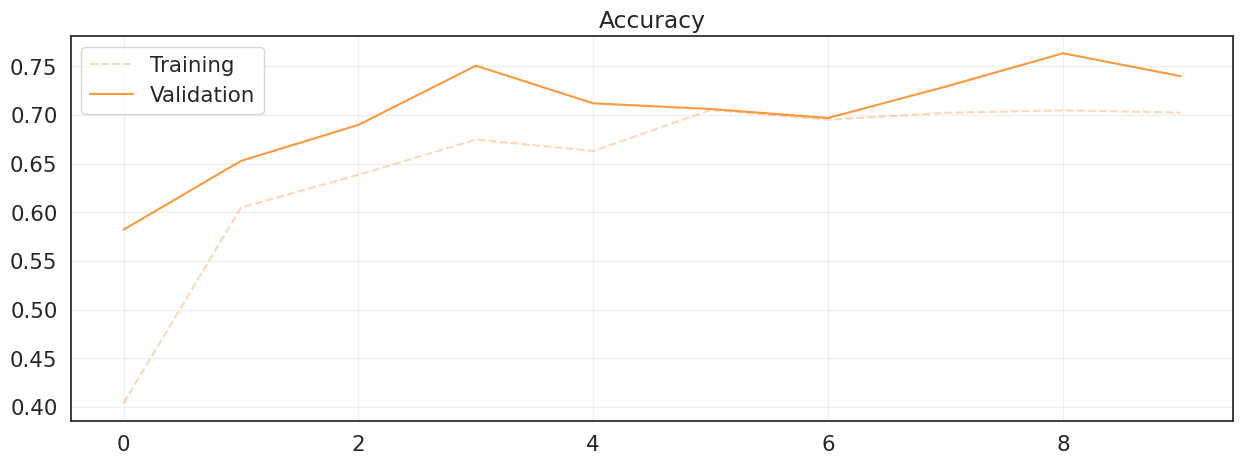

In [ ]:
# Plot the loss function and accuracy value over epochs
utils.plot_history(history)

## Save

In [ ]:
# Saving the model for testing and submission
accuracy = round(max(history['val_accuracy'])* 100, 2)
model_name = f"efficientnetv2l_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")

/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1/models
Saving efficientnetv2l_76.34.keras
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1
Model Saved


## Fine-Tuning


In [ ]:
# Parameter for the model name
model_name = 'efficientnetv2-l'

In [ ]:
# Setting all the parameters of the network as trainable
model.get_layer(model_name).trainable = True

# Setting all layers as not trainable since there is no necessity to train again all layers
for layer in model.get_layer(model_name).layers:
    layer.trainable = False

# Setting only Convolutional as trainable
for i, layer in enumerate(model.get_layer(model_name).layers):
    if isinstance(layer, tfkl.Conv2D) or isinstance(layer, tfkl.SeparableConv2D) or isinstance(layer, tfkl.DepthwiseConv2D):
        layer.trainable = True

# Setting a depth to which we freeze the training (0 to 60)
FREEZE_DEPTH = 60
for layer in model.get_layer(model_name).layers[:FREEZE_DEPTH]:
    layer.trainable = False

# Print model details
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-l (Functional)        │ (None, 3, 3, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,011,914 (511.21 MB)

 Trainable params: 121,257,784 (462.56 MB)

 Non-trainable params: 1,910,752 (7.29 MB)

 Optimizer params: 10,843,378 (41.36 MB)

In [ ]:
# Parameters used for Fine Tuning
FT_LEARNING_RATE = 1e-4

In [ ]:
# Model compilation with Adam as optimizer and sparse categorical crossentropy as loss function
model.compile(optimizer=tfk.optimizers.Adam(FT_LEARNING_RATE),
                loss=tfk.losses.CategoricalCrossentropy(), #Sparse since we are not one-hot-encoding (no difference)
                metrics=['accuracy'])

In [ ]:
EPOCHS = 150
PATIENCE = 20

In [ ]:
# Implementation of early stopping as a technique to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
callbacks = [early_stopping]

In [ ]:
# Actual Fine Tuning of the model with the given parameters
finetuned_history = model.fit(  train_data,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                callbacks=callbacks,
                                validation_data= val_data ).history

Epoch 1/150
262/262 ━━━━━━━━━━━━━━━━━━━━ 321s 568ms/step - accuracy: 0.5469 - loss: 1.4527 - val_accuracy: 0.8464 - val_loss: 0.6371
Epoch 2/150
262/262 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.8448 - loss: 0.6399 - val_accuracy: 0.8554 - val_loss: 0.5912
Epoch 3/150
262/262 ━━━━━━━━━━━━━━━━━━━━ 42s 151ms/step - accuracy: 0.8805 - loss: 0.5306 - val_accuracy: 0.8777 - val_loss: 0.5565
Epoch 4/150
262/262 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.8667 - loss: 0.5489 - val_accuracy: 0.8823 - val_loss: 0.5331
Epoch 5/150
262/262 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.9075 - loss: 0.4633 - val_accuracy: 0.8942 - val_loss: 0.4936
Epoch 6/150
262/262 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - accuracy: 0.8835 - loss: 0.5207 - val_accuracy: 0.8888 - val_loss: 0.5050
Epoch 7/150
262/262 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9076 - loss: 0.4276 - val_accuracy: 0.9003 - val_loss: 0.4845
Epoch 8/150
262/262 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.9048 

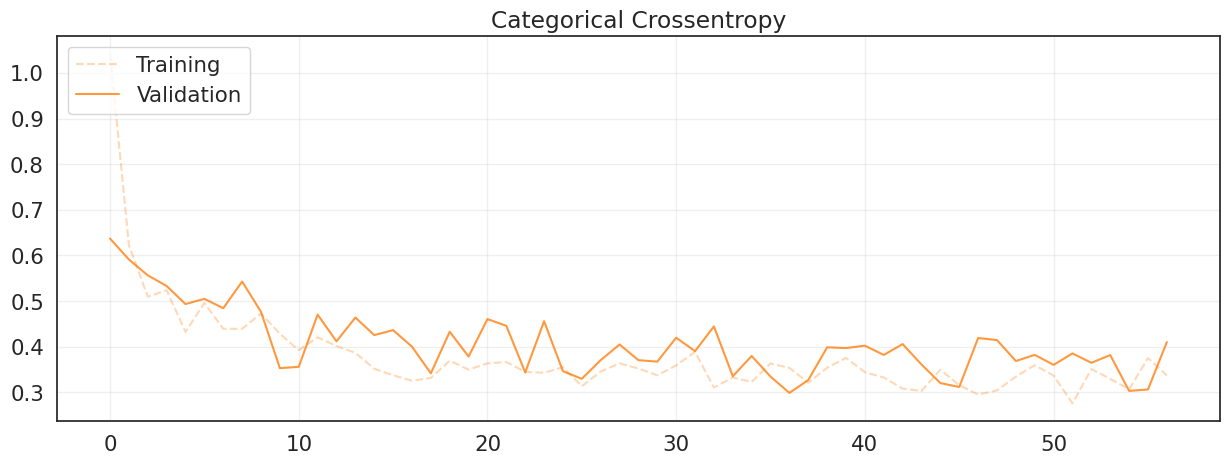

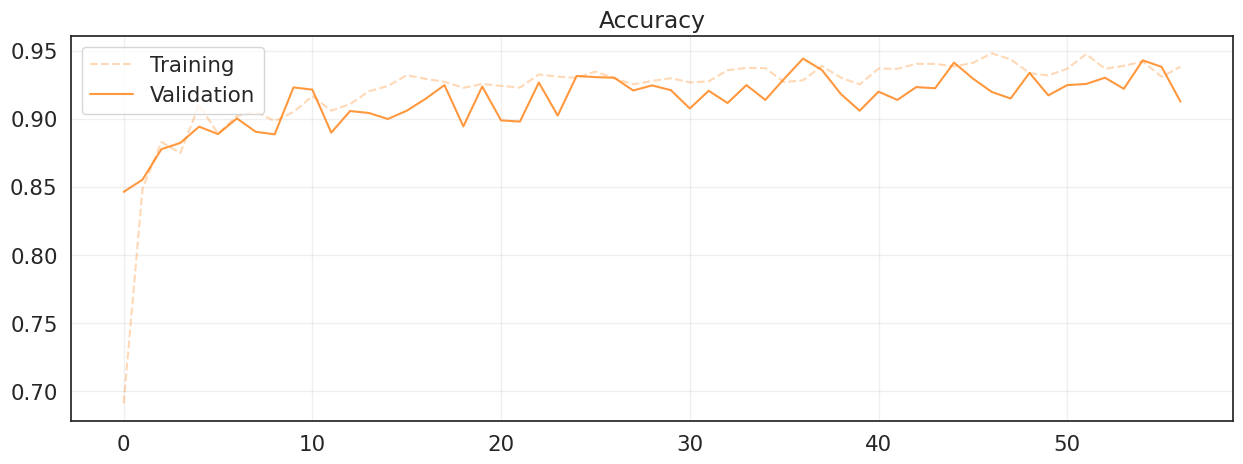

In [ ]:
# Plot the loss function and accuracy value over epochs
utils.plot_history(finetuned_history)

In [ ]:
# Saving the model for testing and submission
accuracy = round(max(finetuned_history['val_accuracy'])* 100, 2)
model_name = f"efficientnetv2-l_ft_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")

/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1/models
Saving efficientnetv2-l_ft_94.42.keras
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1
Model Saved


## Test Prediction and Final Evaluation

In [ ]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=1)

In [ ]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(y_test, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(y_test, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(y_test, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

Accuracy score over the test set: 0.9841
Precision score over the test set: 0.9846
Recall score over the test set: 0.9841
F1 score over the test set: 0.9842
